In [1]:
import seaborn as sns
# import matplotlib.pyplot as plt
# import xgboost as xgb
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import *
from sklearn.metrics import *
import numpy as np
import pandas as pd
import warnings
# import optuna
# from scipy.stats import randint
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('./datasets/mushroom.csv')
df2 = pd.read_csv('./datasets/mushrooms.csv')

# rename columns
df2.rename(columns={'bruises':'ruises'}, inplace=True)

# df = pd.concat([df, df2], axis=0)
# df = pd.concat([df, df2], axis=0)

In [4]:
df.head()

,class,cap-shape,cap-surface,cap-color,ruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,x,f,n,f,n,f,w,n,b,t,NaN,s,y,w,p,NaN,n,o,p,w,v,NaN
1,p,NaN,y,g,t,NaN,f,c,b,k,e,b,f,s,n,c,p,w,n,e,NaN,y,g
2,e,b,y,n,t,n,f,c,NaN,n,t,r,s,s,p,NaN,p,w,o,p,b,y,w
3,e,x,g,g,t,n,f,w,b,n,t,b,s,s,p,NaN,p,w,n,n,NaN,NaN,d
4,e,NaN,f,NaN,t,n,a,w,n,n,e,?,s,k,NaN,w,p,w,NaN,l,w,v,d


In [5]:
# print(data.describe())

# 统计所有行列中 NaN的个数的分布
distri = {}
for row in df.iterrows():
    cnt = 0
    for cell in row[1]:
        if str(cell) == 'nan':
            cnt += 1

    if cnt not in distri:
        distri[cnt] = 1
    distri[cnt] += 1


# # 画图
# sns.barplot(x=list(distri.keys()), y=list(distri.values()))

In [6]:
# 计算缺失值的比例
ratio = {}
for key in distri.keys():
    ratio[key] = distri[key] / df.shape[0]

sum_list = []
for i in range(0, len(ratio)):
    s = 0
    # 加上比i小的所有比例
    for j in range(0, i):
        s += ratio[j]
    sum_list.append(s)

# 画折线图
# sns.lineplot(x=range(0, len(ratio) ), y=pd.Series(sum_list))
# print(sum_list)


# find the last 97%
i = 0
while sum_list[i] < 0.95:
    i += 1

## 丢弃缺失值个数超过i 的行

In [7]:
# 丢弃缺失值个数超过i 的行
for row in df.iterrows():
    cnt = 0
    for cell in row[1]:
        if str(cell) == 'nan':
            cnt += 1
    if cnt > i:
        df.drop(row[0], inplace=True)

In [8]:
print(df.isna().sum().sum())
print(df.duplicated().sum())

75310
0


## 丢弃 

In [9]:
df.drop(columns = ['veil-type'], inplace = True)
df.drop(columns=['veil-color'], inplace=True)
df.drop(columns=['gill-attachment'], inplace=True)
df.drop(columns=['cap-color'], inplace=True)


## 编码插值

In [10]:
# # 用众数填充缺失值
# df = df.apply(lambda x: x.fillna(df.mode().iloc[0]))

# x = df.drop('class', axis=1)
# y = df['class']

# x = OneHotEncoder().fit_transform(x)
# y = LabelEncoder().fit_transform(y)

In [11]:
from sklearn.impute import KNNImputer
mask = df.isnull()
df.dropna()

# 填充缺失值
df.fillna(df.mode().iloc[0], inplace=True)

# class 使用 OneHotEncoder
label = OneHotEncoder().fit_transform(df['class'].values.reshape(-1, 1)).toarray()
# 其余使用 LabelEncoder 编码

for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# 将 class 重新加入
df['class'] = label

df.where(~mask, np.nan, inplace=True)

# fill na with average
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

# KNN Imputer
df = pd.DataFrame(KNNImputer(
    n_neighbors=5).fit_transform(df), columns=df.columns)

df.head()

x = df.drop('class', axis=1)
y = df['class']


## 正态分析

In [12]:
# for feature in df.columns:
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1

# def outlier_treatment(colume_name) -> None:
#     global df
#     Q1, Q3 = df[colume_name].quantile([0.25, 0.75])
#     IQR = Q3 - Q1
    
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     outliers_iqr = df[(df[colume_name] < lower_bound) | (df[colume_name] > upper_bound)]
    
#     if outliers_iqr.empty:
#         print(f'No outliers found in {colume_name}')
#     else:
#         # drop
#         print(f'Outliers found in {colume_name}, dropping {outliers_iqr.shape[0]} rows')
#         df.drop(outliers_iqr.index, inplace=True)
#         df = df.reset_index(drop = True)

# for feature in df.columns:
#     outlier_treatment(feature)

# # ret = process_map(outlier_treatment, df.columns)

## 数据集划分

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(20654, 18) (20654,)
(5164, 18) (5164,)


## 模型训练

In [14]:
model_result = [
    
]
# {
#     'model': 'name',
#     'result': 'list'
# }

# f1 = make_scorer(f1_score, average='weighted')

### SVM - Baseline

In [15]:
# svm_model = SVC()
# svm_model.fit(x_train, y_train)

# svm_pred = svm_model.predict(x_test)

# model_result.append({
#     'model': 'SVM',
#     'result': svm_pred
# })

#### 测试结果

In [16]:
# ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
# plt.show()

# print(classification_report(y_test, svm_pred))

### SVM 贝叶斯优化

In [17]:
# def objective(trial):
#     C = trial.suggest_loguniform('C', 1e-3, 1e3)
#     gamma = trial.suggest_loguniform('gamma', 1e-3, 1e-1)
#     kernel = trial.suggest_categorical('kernel', ['rbf'])

#     svc = SVC(C=C, gamma=gamma, kernel=kernel)
    
#     # f1_score
#     score = cross_val_score(svc, x_train, y_train, cv=5, scoring=f1).mean()
#     return score

# study = optuna.create_study(direction='maximize')


In [18]:
# study.optimize(objective, n_trials=96, n_jobs=-1)

In [19]:
# # svm_model = SVC(C=study.best_params['C'], gamma=study.best_params['gamma'], kernel=study.best_params['kernel'])
# best = {'C': 0.17284149315658728, 'gamma': 0.0015771661832327244, 'kernel': 'rbf'}
# svm_model = SVC(C=best['C'], gamma=best['gamma'], kernel=best['kernel'])
# svm_model.fit(x_train, y_train)

# svm_pred = svm_model.predict(x_test)

# model_result.append({
#     'model': 'SVM',
#     'result': svm_pred
# })

#### 测试结果

In [20]:
# ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
# plt.show()

# print(classification_report(y_test, svm_pred))

### GradientBoostingClassifier

In [21]:
# gb_model = GradientBoostingClassifier()

# parameters = {
#     'n_estimators': np.arange(50, 500, 50),
#     'max_depth': np.arange(1, 10, 1),
#     'learning_rate': np.logspace(-3, 2, 10)
# }

# grid_search = GridSearchCV(gb_model, parameters, cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(x_train, y_train)



In [22]:
# print(grid_search.best_params_)


In [23]:
# best_params_ = {
#     'learning_rate': np.float64(0.1668100537200059), 'max_depth': np.int64(2), 'n_estimators': np.int64(150)}

# gb_model = GradientBoostingClassifier(**best_params_)
# gb_model.fit(x_train, y_train)
 
# gb_pred = gb_model.predict(x_test)

# model_result.append({
#     'model': 'GradientBoosting',
#     'result': gb_pred
# })

#### 测试结果

In [24]:
# ConfusionMatrixDisplay.from_predictions(y_test, gb_pred)
# plt.show()

# print(classification_report(y_test, gb_pred))

### AdaBoostClassifier

In [41]:
# ada_model = AdaBoostClassifier()

# parameters = {
#     'n_estimators': np.arange(50, 500, 20),
#     'learning_rate': np.logspace(-3, 2, 20),
#     'algorithm': ['SAMME']
# }

# grid_search = GridSearchCV(ada_model, parameters, n_jobs=-1, cv=5, verbose=1)
# grid_search.fit(x_train, y_train)

# ada_model = AdaBoostClassifier(n_estimators=grid_search.best_params_[
#                                'n_estimators'], learning_rate=grid_search.best_params_['learning_rate'])

best_params = {'algorithm': 'SAMME',
               'learning_rate': 0.774263682681127, 'n_estimators': 150}

ada_model = AdaBoostClassifier(
    n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], algorithm=best_params['algorithm'])

ada_model.fit(x_train, y_train)

ada_pred = ada_model.predict(x_test)

model_result.append({
    'model': 'AdaBoost',
    'result': ada_pred
})

In [26]:
# ada_model.feature_importances_.shape

In [27]:
# # 特征重要性
# import seaborn as sns

# feature = pd.DataFrame({
#     'feature': x.columns,
#     'importance': ada_model.feature_importances_
# })

# feature.sort_values(by='importance', ascending=False, inplace=True)

# print(feature)

In [28]:
# import joblib
# import time
# joblib.dump(ada_model, f'./results/ada_model_{time.strftime("%Y-%m-%d-%H-%M-%S")}.pkl')

#### 测试结果

In [42]:
print(classification_report(y_test, ada_pred))
print(f1_score(y_test, ada_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.71      0.72      2325
         1.0       0.77      0.78      0.78      2873

    accuracy                           0.75      5198
   macro avg       0.75      0.75      0.75      5198
weighted avg       0.75      0.75      0.75      5198

0.7759751467034864


### LSTM

In [30]:
# # 长短期记忆网络 

# from keras.models import Sequential
# from keras.layers import Dense, LSTM

# model = Sequential()

# model.add(LSTM(128, input_shape=(x_train.shape[1], 1)))
# model.add(Dense(1, activation='sigmoid'))

# # metrics f1_score
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [31]:
# # with test
# model.fit(x_train, y_train, epochs=100, batch_size=256, validation_data=(x_test, y_test))

# lstm_pred = model.predict(x_test)

# model_result.append({
#     'model': 'LSTM',
#     'result': lstm_pred
# })

### RNN

In [32]:
# # RNN

# from keras.layers import SimpleRNN
# from keras.models import *
# from keras.layers import *

# rnn_model = Sequential()

# rnn_model.add(SimpleRNN(128, input_shape=(x_train.shape[1], 1)))
# rnn_model.add(Dense(1, activation='sigmoid'))

# rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# rnn_model.fit(x_train, y_train, epochs=100, batch_size=256, validation_data=(x_test, y_test))

# rnn_pred = rnn_model.predict(x_test)

# model_result.append({
#     'model': 'RNN',
#     'result': rnn_pred
# })

### MLP 多层感知机

In [34]:
# # MLP

# from keras.layers import *
# from keras.models import *
# from keras.activations import *
# from keras.optimizers import *
# from keras.losses import *

# mlp_model = Sequential()

# mlp_model.add(Dense(4096, input_shape=(x_train.shape[1],)))
# mlp_model.add(Activation('relu'))
# # mlp_model.add(Dense(2048))
# # mlp_model.add(Activation('relu'))
# # mlp_model.add(Dense(1024))
# # mlp_model.add(Activation('relu'))
# mlp_model.add(Dense(512))
# mlp_model.add(Activation('relu'))
# mlp_model.add(Dense(256))
# mlp_model.add(Activation('relu'))
# mlp_model.add(Dense(128))
# mlp_model.add(Activation('relu'))
# mlp_model.add(Dense(64))
# mlp_model.add(Activation('relu'))
# mlp_model.add(Dense(32))
# mlp_model.add(Activation('relu'))
# mlp_model.add(Dense(1))
# mlp_model.add(Activation('sigmoid'))

# mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
# mlp_model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

# mlp_pred = mlp_model.predict(x_test)

# # 

### DNN

In [46]:
# DNN
from keras.layers import *
from keras.models import *
from keras.activations import *
from keras.optimizers import *
from keras.losses import *
from keras.callbacks import *

class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).argmax(axis=1)
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average="macro")
        print(f' — val_f1: {_val_f1:.4f}')
        logs['val_f1'] = _val_f1

dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [37]:
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
f1_score_callback = F1ScoreCallback(validation_data=(x_test, y_test))

history = dnn_model.fit(x_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping, f1_score_callback])

Epoch 1/20
646/646 [==============================] - 0s 527us/step - loss: 0.6577 - accuracy: 0.6110
Epoch 2/20
646/646 [==============================] - 0s 490us/step - loss: 0.6021 - accuracy: 0.6798
Epoch 3/20
646/646 [==============================] - 0s 481us/step - loss: 0.5695 - accuracy: 0.7071
Epoch 4/20
646/646 [==============================] - 0s 477us/step - loss: 0.5633 - accuracy: 0.7148
Epoch 5/20
646/646 [==============================] - 0s 489us/step - loss: 0.5567 - accuracy: 0.7151
Epoch 6/20
646/646 [==============================] - 0s 511us/step - loss: 0.5535 - accuracy: 0.7153
Epoch 7/20
646/646 [==============================] - 0s 541us/step - loss: 0.5504 - accuracy: 0.7170
Epoch 8/20
646/646 [==============================] - 0s 527us/step - loss: 0.5461 - accuracy: 0.7223
Epoch 9/20
646/646 [==============================] - 0s 561us/step - loss: 0.5427 - accuracy: 0.7215
Epoch 10/20
646/646 [==============================] - 0s 482us/step - loss: 0.540

 — val_f1: 0.3091


  0%|          | 0/100 [00:00<?, ?it/s]

Best threshold: 0.44, Best f1_score: 0.7722464219041693


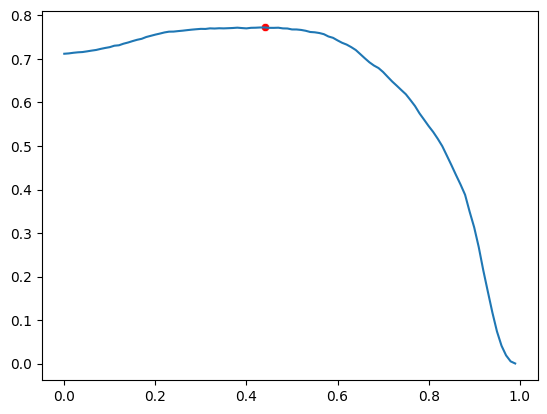

In [63]:
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
f1_score_callback = F1ScoreCallback(validation_data=(x_test, y_test))

history = dnn_model.fit(x_train, y_train, epochs=1, batch_size=32, callbacks=[early_stopping, f1_score_callback],verbose=0)

dnn_pred = dnn_model.predict(x_test)

def test(thres):
    label = np.where(dnn_pred > thres, 1, 0)
    
    return f1_score(y_test, label)

threshold = np.arange(0, 1, 0.01)

from tqdm.contrib.concurrent import process_map

score = process_map(test, threshold)

sns.lineplot(x=threshold, y=score)
# plot the best threshold point
best = np.argmax(score)
sns.scatterplot(x=[threshold[best]], y=[score[best]], color='red')
print(f'Best threshold: {threshold[best]}, Best f1_score: {score[best]}')

## 模型对比

In [39]:
name = [i.get('model') for i in model_result]
results = [i.get('result') for i in model_result]


accuracy = [accuracy_score(y_test, i) for i in results]
precision = [precision_score(y_test, i) for i in results]
recall = [recall_score(y_test, i) for i in results]
f1 = [f1_score(y_test, i) for i in results]
auc = [roc_auc_score(y_test, i) for i in results]

table = pd.DataFrame({
    'name': name,
    'f1': f1,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'auc': auc
})

# sort by accuracy
table = table.sort_values(by='f1', ascending=False)

print(table)


       name        f1  accuracy  precision    recall       auc
0  AdaBoost  0.773135  0.745546   0.757699  0.789214  0.740761


In [40]:
import pathlib
import joblib

df = pd.read_csv('./datasets/mushroom.csv')
df2 = pd.read_csv('./datasets/mushrooms.csv')

# rename columns
df2.rename(columns={'bruises':'ruises'}, inplace=True)

# df = pd.concat([df, df2], axis=0)
# df = pd.concat([df, df2], axis=0)

df.drop(columns = ['veil-type'], inplace = True)
df.drop(columns=['veil-color'], inplace=True)
df.drop(columns=['gill-attachment'], inplace=True)
df.drop(columns=['cap-color'], inplace=True)


from sklearn.impute import KNNImputer
mask = df.isnull()

# 填充缺失值
df.fillna(df.mode().iloc[0], inplace=True)

# class 使用 OneHotEncoder
label = OneHotEncoder().fit_transform(df['class'].values.reshape(-1, 1)).toarray()
# 其余使用 LabelEncoder 编码

for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# 将 class 重新加入
df['class'] = label

df.where(~mask, np.nan, inplace=True)

# fill na with average
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

# KNN Imputer
df = pd.DataFrame(KNNImputer(
    n_neighbors=5).fit_transform(df), columns=df.columns)


df.head()

x = df.drop('class', axis=1)
y = df['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

name = []
accuracy = []
precision = []
recall = []
f1 = []
auc = []

for path in pathlib.Path('./results').glob('*.pkl'):
    try:
        model = joblib.load(path)
        pred = model.predict(x_test)
        
        name.append(path.stem)
        accuracy.append(accuracy_score(y_test, pred))
        precision.append(precision_score(y_test, pred))
        recall.append(recall_score(y_test, pred))
        f1.append(f1_score(y_test, pred))
        auc.append(roc_auc_score(y_test, pred))
    except Exception as e:
        print(path)

print(pd.DataFrame({
    'name': name,
    'f1': f1,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'auc': auc
}).sort_values(by='f1', ascending=False))

(20788, 18) (20788,)
(5198, 18) (5198,)
                            name        f1  accuracy  precision    recall  \
1  ada_model_2024-07-18-01-53-20  0.781538  0.754136   0.767887  0.795684   
2  ada_model_2024-07-18-01-53-49  0.780446  0.752020   0.764176  0.797424   
4  ada_model_2024-07-18-02-05-41  0.780446  0.752020   0.764176  0.797424   
0  ada_model_2024-07-18-01-53-06  0.776006  0.751443   0.773057  0.778977   
3  ada_model_2024-07-18-01-53-54  0.772664  0.749134   0.774013  0.771319   

        auc  
1  0.749240  
2  0.746669  
4  0.746669  
0  0.748198  
3  0.746520  
